In [1]:
import numpy as np
import pandas as pd
import regex as re
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.utils import class_weight
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.svm import SVC

# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rkroc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rkroc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv('clean_data.csv')

In [3]:
data.isnull().sum() # number of nulls in the data

tweet        134
target         0
hashtag    40728
name       29594
url        43391
emoji      47252
dtype: int64

In [4]:
data = data.fillna('') # filling the null value with an empty text

In [5]:
data['target'].value_counts(normalize=1)*100 # data looks moreover balanced

religion               16.770108
age                    16.757527
gender                 16.717689
ethnicity              16.692527
not_cyberbullying      16.658978
other_cyberbullying    16.403170
Name: target, dtype: float64

In [6]:
#converting the target column into numerical form using one hot encoding
LE = LabelEncoder()
LE.fit(data['target'])
data['target'] = LE.transform(data['target'])
LE_name_mapping = dict(zip(LE.classes_, LE.transform(LE.classes_)))
print(LE_name_mapping)

{'age': 0, 'ethnicity': 1, 'gender': 2, 'not_cyberbullying': 3, 'other_cyberbullying': 4, 'religion': 5}


In [7]:
data['target'].value_counts(normalize=1)*100

5    16.770108
0    16.757527
2    16.717689
1    16.692527
3    16.658978
4    16.403170
Name: target, dtype: float64

In [8]:
# getting the length for each of the hashtag name url and emoji column
for col in ['hashtag','name','url','emoji']:
    data[col+"_len"] = data[col].apply(lambda x:len(x))
data

,tweet,target,hashtag,name,url,emoji,hashtag_len,name_len,url_len,emoji_len
0,in other words your food was crapilicious,3,"['katandandre', 'mkr']",,,,22,0,0,0
1,why is so white studio,3,"['aussietv', 'mkr', 'theblock', 'imacelebritya...",,,,119,0,0,0
2,a classy whore or more red velvet cupcakes,3,,['xochitlsuckkks'],,,0,18,0,0
3,meh p thanks for the heads up but not too conc...,3,,['jasongio'],,,0,12,0,0
4,this is an isis account pretending to be a kur...,3,,['rudhoeenglish'],,,0,17,0,0
...,...,...,...,...,...,...,...,...,...,...
47687,black ppl arent expected to do anything depend...,1,,,,,0,0,0,0
47688,turner did not withhold his disappointment tur...,1,,,,,0,0,0,0
47689,i swear to god this dumb nigger bitch i have g...,1,,,,,0,0,0,0
47690,yea fuck you rt if youre a nigger fucking unfo...,1,,['therealexel'],,,0,15,0,0


In [9]:
#adding some preprocessing to clean some faetures(hashtag,name,url,emoji)
for col in ['hashtag','name','url','emoji']:
    data[col] = data[col].apply(lambda x:re.sub(r"[,']",'',x))
for col in ['hashtag','name','url','emoji']:
    data[col] = data[col].str.replace("[",'')
    data[col] = data[col].str.replace("]",'')
    if col =='emoji':
        data[col] = data[col].str.replace("_",' ')
        

<ipython-input-9-b9a156eee389>:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  data[col] = data[col].str.replace("[",'')
<ipython-input-9-b9a156eee389>:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  data[col] = data[col].str.replace("]",'')


In [10]:
data

,tweet,target,hashtag,name,url,emoji,hashtag_len,name_len,url_len,emoji_len
0,in other words your food was crapilicious,3,katandandre mkr,,,,22,0,0,0
1,why is so white studio,3,aussietv mkr theblock imacelebrityau today sun...,,,,119,0,0,0
2,a classy whore or more red velvet cupcakes,3,,xochitlsuckkks,,,0,18,0,0
3,meh p thanks for the heads up but not too conc...,3,,jasongio,,,0,12,0,0
4,this is an isis account pretending to be a kur...,3,,rudhoeenglish,,,0,17,0,0
...,...,...,...,...,...,...,...,...,...,...
47687,black ppl arent expected to do anything depend...,1,,,,,0,0,0,0
47688,turner did not withhold his disappointment tur...,1,,,,,0,0,0,0
47689,i swear to god this dumb nigger bitch i have g...,1,,,,,0,0,0,0
47690,yea fuck you rt if youre a nigger fucking unfo...,1,,therealexel,,,0,15,0,0


In [11]:
text_col = data.loc[:,data.dtypes=='object'].columns
text_col

Index(['tweet', 'hashtag', 'name', 'url', 'emoji'], dtype='object')

# Removing the stop words

In [12]:

stop_words = stopwords.words('english')
stop_words.extend(['rt', 'mkr', 'didn', 'bc', 'n', 'm', 'im', 'll', 'y', 've', 'u', 'ur', 'don', 't', 's','etc'])
for col in text_col:
    data[col] = data[col].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    print("Done! {}".format(col))
data.head()

Done! tweet
Done! hashtag
Done! name
Done! url
Done! emoji


,tweet,target,hashtag,name,url,emoji,hashtag_len,name_len,url_len,emoji_len
0,words food crapilicious,3,katandandre,,,,22,0,0,0
1,white studio,3,aussietv theblock imacelebrityau today sunrise...,,,,119,0,0,0
2,classy whore red velvet cupcakes,3,,xochitlsuckkks,,,0,18,0,0
3,meh p thanks heads concerned another angry dud...,3,,jasongio,,,0,12,0,0
4,isis account pretending kurdish account like i...,3,,rudhoeenglish,,,0,17,0,0


# using the TF-IDF vectorizer

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

In [20]:
cv_t = TfidfVectorizer(max_features = 500,ngram_range=(1,3))
t_array = cv_t.fit_transform(data['tweet']).toarray()

In [21]:
cv_h = TfidfVectorizer(max_features = 100,ngram_range=(1,1))
h_array = cv_h.fit_transform(data['hashtag']).toarray()

In [22]:
cv_e = TfidfVectorizer(max_features = 100,ngram_range=(1,1))
e_array = cv_e.fit_transform(data['emoji']).toarray()

In [23]:
extra = data[['hashtag_len','name_len','url_len','emoji_len']].values
extra = np.asarray(extra)

In [24]:
X = np.hstack((t_array,h_array,e_array,extra))
y = data['target'].values

In [25]:
print(X.shape,y.shape)

(47692, 704) (47692,)


In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [27]:
#importing the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,f1_score,classification_report

In [28]:
#Decision tree Classifier
clf = DecisionTreeClassifier()
clf.fit(X_train,y_train)
pred= clf.predict(X_test)
acc = f1_score(pred,y_test,average='micro')
print(acc)
print(confusion_matrix(y_test,pred))

0.7737708355173498
[[1492    6    7   29   20    3]
 [   5 1569   10   15   20    8]
 [   1   17 1305  152  128   23]
 [  29    9  137  759  572   66]
 [  13   11  114  567  792   22]
 [   5   11   35   74   49 1464]]


In [29]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1557
           1       0.97      0.96      0.97      1627
           2       0.81      0.80      0.81      1626
           3       0.48      0.48      0.48      1572
           4       0.50      0.52      0.51      1519
           5       0.92      0.89      0.91      1638

    accuracy                           0.77      9539
   macro avg       0.77      0.77      0.77      9539
weighted avg       0.78      0.77      0.78      9539



# Hyper parametertuning for DT

In [ ]:
pgrid = {"max_depth": [3,4,5,6,7],
      "min_samples_split": [5,10,15,20]}
clf = DecisionTreeClassifier()
grid_search = GridSearchCV(clf, param_grid=pgrid, scoring='f1_micro', cv=3,verbose=3)
grid_search.fit(X, y)
print(grid_search.best_params_)
print(grid_search.best_estimator_.score(X_test, y_test))

# Random Forest Classifier

In [30]:
clf = RandomForestClassifier(n_estimators=100,random_state=1,n_jobs=-1)
clf.fit(X_train,y_train)
pred_rf = clf.predict(X_test)
f1_score(y_test,pred_rf,average='micro')

0.8041723451095503

In [26]:
# fold cross validation in order to avoid overfitting anf fet a good relection of model score
from sklearn.model_selection import cross_val_score
clf = RandomForestClassifier(n_estimators=100,random_state=1,n_jobs=-1)
scoring='f1_micro'
scores = cross_val_score(clf, X, y, scoring=scoring, cv=5,verbose=3)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.811) total time=  45.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   45.7s remaining:    0.0s


[CV] END ................................ score: (test=0.807) total time=  50.3s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s


[CV] END ................................ score: (test=0.805) total time=  50.3s
[CV] END ................................ score: (test=0.811) total time=  49.5s
[CV] END ................................ score: (test=0.806) total time=  49.7s
0.81 accuracy with a standard deviation of 0.00


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.1min finished


# Hyper paramter tuning for Random Forest

In [ ]:
#max_features=0.2
pgrid = {"max_features": [0.2, 0.4, 0.8],
        "n_estimators":[100,150,200]}
clf =RandomForestClassifier()
grid_search = GridSearchCV(clf, param_grid=pgrid, scoring='f1_micro', cv=3,verbose=3)
grid_search.fit(X, y)
print(grid_search.best_params_)
print(grid_search.best_estimator_.score(X_test, y_test))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END max_features=0.2, n_estimators=100;, score=0.804 total time= 5.8min
[CV 2/3] END max_features=0.2, n_estimators=100;, score=0.801 total time= 7.0min
[CV 3/3] END max_features=0.2, n_estimators=100;, score=0.803 total time= 8.5min
[CV 1/3] END max_features=0.2, n_estimators=150;, score=0.804 total time=14.9min
[CV 2/3] END max_features=0.2, n_estimators=150;, score=0.801 total time=21.1min
[CV 3/3] END max_features=0.2, n_estimators=150;, score=0.803 total time=30.6min
[CV 1/3] END max_features=0.2, n_estimators=200;, score=0.804 total time=11.2min
[CV 2/3] END max_features=0.2, n_estimators=200;, score=0.801 total time=11.0min
[CV 3/3] END max_features=0.2, n_estimators=200;, score=0.803 total time=11.2min
[CV 1/3] END max_features=0.4, n_estimators=100;, score=0.799 total time=11.0min
[CV 2/3] END max_features=0.4, n_estimators=100;, score=0.797 total time=10.4min
[CV 3/3] END max_features=0.4, n_estimators=100;,

In [228]:
# matrix = confusion_matrix(y_test1, predictions)
# matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# # Build the plot
# plt.figure(figsize=(16,7))
# sns.set(font_scale=1.4)
# sns.heatmap(matrix, annot=True, annot_kws={'size':10},
#             cmap=plt.cm.Greens, linewidths=0.2)

# # Add labels to the plot
# class_names = ['Updates','Personal', 'Promotions','Forums','Purchases','Travel','Spam','Social']
# tick_marks = np.arange(len(class_names))
# tick_marks2 = tick_marks + 0.5
# plt.xticks(tick_marks, class_names, rotation=25)
# plt.yticks(tick_marks2, class_names, rotation=0)
# plt.xlabel('Predicted label')
# plt.ylabel('True label')
# plt.title('Confusion Matrix for XG BOOST Model')
# plt.show()

In [31]:
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier(n_estimators=100)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
f1_score(pred,y_test,average='micro')

0.8025998532340917

# balanced Random Forest classifer in order to handle data imbalance

In [230]:
model_rb1 = BalancedRandomForestClassifier(n_estimators=100) # performs random under sampling of majority class in each sample
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model_rb1, X, y, scoring='f1_micro', cv=cv, n_jobs=-1,verbose=3)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  30 | elapsed: 24.9min remaining:  3.8min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 25.0min finished


0.81 accuracy with a standard deviation of 0.01


# Boosting

In [ ]:
# XG BOOST MODEL

In [37]:
model_xgb = XGBClassifier(objective='multi:softmax',eval_metric='mlogloss')
eval_set = [(X_train, y_train),(X_test,y_test)]
model_xgb.fit(X_train, y_train, eval_metric=["merror","mlogloss"], eval_set=eval_set, verbose=True)

C:\Users\rkroc\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-merror:0.22140	validation_0-mlogloss:1.30121	validation_1-merror:0.22308	validation_1-mlogloss:1.30147
[1]	validation_0-merror:0.20835	validation_0-mlogloss:1.07662	validation_1-merror:0.20998	validation_1-mlogloss:1.07619
[2]	validation_0-merror:0.20533	validation_0-mlogloss:0.93123	validation_1-merror:0.20621	validation_1-mlogloss:0.93203
[3]	validation_0-merror:0.20308	validation_0-mlogloss:0.83056	validation_1-merror:0.20358	validation_1-mlogloss:0.83232
[4]	validation_0-merror:0.19865	validation_0-mlogloss:0.75424	validation_1-merror:0.20023	validation_1-mlogloss:0.75674
[5]	validation_0-merror:0.19713	validation_0-mlogloss:0.69584	validation_1-merror:0.19981	validation_1-mlogloss:0.69876
[6]	validation_0-merror:0.19600	validation_0-mlogloss:0.64921	validation_1-merror:0.19876	validation_1-mlogloss:0.65306
[7]	validation_0-merror:0.19532	validation_0-mlogloss:0.61311	validation_1-merror:0.19729	validation_1-mlogloss:0.61797
[8]	validation_0-merror:0.19280	validati

[68]	validation_0-merror:0.14552	validation_0-mlogloss:0.35504	validation_1-merror:0.16417	validation_1-mlogloss:0.39395
[69]	validation_0-merror:0.14500	validation_0-mlogloss:0.35429	validation_1-merror:0.16396	validation_1-mlogloss:0.39374
[70]	validation_0-merror:0.14473	validation_0-mlogloss:0.35352	validation_1-merror:0.16343	validation_1-mlogloss:0.39337
[71]	validation_0-merror:0.14413	validation_0-mlogloss:0.35280	validation_1-merror:0.16343	validation_1-mlogloss:0.39305
[72]	validation_0-merror:0.14361	validation_0-mlogloss:0.35201	validation_1-merror:0.16301	validation_1-mlogloss:0.39271
[73]	validation_0-merror:0.14334	validation_0-mlogloss:0.35130	validation_1-merror:0.16312	validation_1-mlogloss:0.39252
[74]	validation_0-merror:0.14298	validation_0-mlogloss:0.35057	validation_1-merror:0.16323	validation_1-mlogloss:0.39235
[75]	validation_0-merror:0.14274	validation_0-mlogloss:0.35000	validation_1-merror:0.16323	validation_1-mlogloss:0.39200
[76]	validation_0-merror:0.14219

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [38]:
pred_xgb = model_xgb.predict(X_test) #Evaluating on the test data
f1_score(y_test,pred_xgb,average='micro')

0.8382430024111542

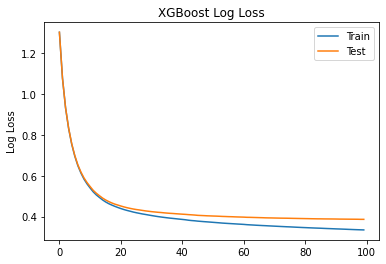

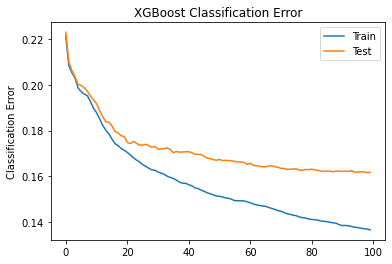

In [39]:
results = model_xgb.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)
#plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
#plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [40]:
print(classification_report(y_test,pred_xgb))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1557
           1       0.99      0.98      0.99      1627
           2       0.94      0.82      0.88      1626
           3       0.64      0.51      0.57      1572
           4       0.57      0.81      0.67      1519
           5       0.97      0.93      0.95      1638

    accuracy                           0.84      9539
   macro avg       0.85      0.84      0.84      9539
weighted avg       0.85      0.84      0.84      9539



In [41]:
#Light Gradient Boosting

In [32]:
import lightgbm as lgb
lgb_class = lgb.LGBMClassifier(n_estimators=100)
lgb_class.fit(X_train,y_train)
lgb_pred = lgb_class.predict(X_test)
f1_score(y_test,lgb_pred,average='micro')

0.8267113953244576

In [ ]:
# Hyper paramter tuning for LGB

In [ ]:
pgrid = { "max_depth":[2,3,5,7],
       "n_estimators":[100,150,200]}
        "learning_rate":[0.01,0.05,0.1],
         "reg_lambda":[i/10.0 for i in range(0,11,3)] }
clf =lgb.LGBMClassifier(objective='multiclass',metric='multi_logloss')
grid_search = GridSearchCV(clf, param_grid=pgrid, scoring='f1_micro', cv=10,verbose=3)
grid_search.fit(X, y)
print(grid_search.best_params_)
print(grid_search.best_estimator_.score(X_test, y_test))